# Maximum Likelihood and Weight Sensitivity.

In [99]:
import autograd
from autograd import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import paragami

# Use the original scipy for functions we don't need to differentiate.
import scipy as osp

import time


## Define a Model.

For illustration, let's consider a simple example: a Gaussian maximum likelihood estimator.

$$
x_n \overset{iid}\sim \mathcal{N}(\mu, \Sigma)\textrm{, for }n=1,...,N.
$$

The "model parameters" are $\mu$ and $\Sigma$, and we will estimate them using maximum likelihood estimation (MLE). Let the data be denoted by $X = (x_1, ..., x_N)$.  For a given set of data weights $W = (w_1, ..., w_N)$, we can define the loss

$$
\ell(X, W, \mu, \Sigma) = \frac{1}{2}\sum_{n=1}^N w_n \left((x_n - \mu)^T \Sigma^{-1} (x_n - \mu) + \log |\Sigma| \right).
$$

The loss on the original dataset is given when $W_1=(1,...,1)$, so we will take the MLE to be

$$
\hat\mu, \hat\Sigma = \mathrm{argmax} \ell(X, W_1, \mu, \Sigma).
$$

We will consider approximating the effect of varying $W$ on the optimal value in the sensitivity section below.

Of course, this example has a closed-form optimum as a function of the weights, $W$:

$$
\begin{align}
\hat\mu(W) = \frac{1}{\sum_{n=1}^N w_n} \sum_{n=1}^N w_n x_n \quad\quad\quad
\hat\Sigma(W) = \frac{1}{\sum_{n=1}^N w_n} 
    \sum_{n=1}^N w_n \left(x_n - \hat\mu(W) \right) \left(x_n - \hat\mu(W) \right)^T\\
\end{align}
$$

However, for expository purposes let us treat it as a generic optimization problem.

### Specify Parameters and Draw Data.

In [2]:
np.random.seed(42)

num_obs = 1000

# True values of parameters
true_sigma = \
    np.eye(3) * np.diag(np.array([1, 2, 3])) + \
    np.random.random((3, 3)) * 0.1
true_sigma = 0.5 * (true_sigma + true_sigma.T)

true_mu = np.array([0, 1, 2])

# Data
x = np.random.multivariate_normal(
    mean=true_mu, cov=true_sigma, size=(num_obs, ))

# Original weights.
original_weights = np.ones(num_obs)

### Write out the log likelihood and use it to specify a loss function.

In [3]:
def get_normal_log_prob(x, sigma, mu):
    sigma_inv = np.linalg.inv(sigma)
    sigma_det_sign, sigma_log_det = np.linalg.slogdet(sigma)
    if sigma_det_sign <= 0:
        return np.full(float('inf'), x.shape[0])
    else:
        x_centered = x - np.expand_dims(mu, axis=0)
        return -0.5 * (
            np.einsum('ni,ij,nj->n', x_centered, sigma_inv, x_centered) + \
            sigma_log_det)

# The loss function is the weighted negative of the log likelihood.
def get_loss(norm_param_dict, x, weights):
    return np.sum(
        -1 * weights * get_normal_log_prob(
            x, norm_param_dict['sigma'], norm_param_dict['mu']))

true_norm_param_dict = dict()
true_norm_param_dict['sigma'] = true_sigma
true_norm_param_dict['mu'] = true_mu

print('Loss at true parameter: {}'.format(
    get_loss(true_norm_param_dict, x, original_weights)))

Loss at true parameter: 2392.751922600241


## Flatten and Fold for Optimization.

Note that we have written our loss, `get_loss` as a function of a *dictionary of parameters*, ``norm_param_dict``.

We can use `paragami` to convert such a dictionary to and from a flat, unconstrained parameterization for optimization.

### Define a `paragami` pattern that matches the input to `get_loss`.

In [4]:
norm_param_pattern = paragami.PatternDict()
norm_param_pattern['sigma'] = paragami.PSDSymmetricMatrixPattern(size=3)
norm_param_pattern['mu'] = paragami.NumericArrayPattern(shape=(3, ))

### "Flatten" the dictionary into an unconstrained vector.

In [5]:
norm_param_freeflat = norm_param_pattern.flatten(true_norm_param_dict, free=True)
print('The flat parameter has shape: {}'.format(norm_param_freeflat.shape))

The flat parameter has shape: (9,)


### Optimize using ``autograd``.

We can use this flat parameter to optimize the likelihood directly without worrying about the PSD constraint on $\Sigma$.

In [100]:
print('First, wrap the loss to be a function of the model parameters alone.\n')
get_param_loss = paragami.Functor(original_fun=get_loss, argnums=0)
get_param_loss.cache_args(None, x, original_weights)

print('The functor matches the original function with the cached arguments\n' +
      'but is only a function of the model parameters.  (This could also\n' +
      'be accomplished with lambda functions.)')
print('Functor at true parameter:\t{}'.format(
      get_param_loss(true_norm_param_dict)))
print('Loss at true parameter:\t\t{}'.format(
      get_loss(true_norm_param_dict, x, original_weights)))

print('\nNext, wrap the loss to be a function of the flat parameter.')
get_freeflat_loss = paragami.FlattenedFunction(
    original_fun=get_param_loss,
    patterns=norm_param_pattern,
    free=True)

print('Finally, use the flattened function to optimize with autograd.\n')
get_freeflat_loss_grad = autograd.grad(get_freeflat_loss)
get_freeflat_loss_hessian = autograd.hessian(get_freeflat_loss)

# Initialize with zeros.
init_param = np.zeros(norm_param_pattern.flat_length(free=True))
mle_opt = osp.optimize.minimize(
    method='trust-ncg',
    x0=init_param,
    fun=get_freeflat_loss,
    jac=get_freeflat_loss_grad,
    hess=get_freeflat_loss_hessian,
    options={'gtol': 1e-12, 'disp': False})

First, wrap the loss to be a function of the model parameters alone.

The functor matches the original function with the cached arguments
but is only a function of the model parameters.  (This could also
be accomplished with lambda functions.)
Functor at true parameter:	2392.751922600241
Loss at true parameter:		2392.751922600241

Next, wrap the loss to be a function of the flat parameter.
Finally, use the flattened function to optimize with autograd.



### "Fold" to inspect the result.

We can now "fold" the optimum back into its original shape for inspection and further use.

In [101]:
norm_param_opt = norm_param_pattern.fold(mle_opt.x, free=True)

for param in ['sigma', 'mu']:
    print('Parmeter {}\nOptimal:\n{}\n\nTrue:\n{}\n\n'.format(
        param, norm_param_opt[param], true_norm_param_dict[param]))

Parmeter sigma
Optimal:
[[ 1.06683522  0.07910048  0.04229475]
 [ 0.07910048  1.89297797 -0.02650233]
 [ 0.04229475 -0.02650233  2.92376984]]

True:
[[1.03745401 0.07746864 0.03950388]
 [0.07746864 2.01560186 0.05110853]
 [0.03950388 0.05110853 3.0601115 ]]


Parmeter mu
Optimal:
[-0.04469438  1.03094019  1.8551187 ]

True:
[0 1 2]




## Sensitivity Analysis for Approximate LOO.

Suppose we are interested in how our estimator would change if we left out one datapoint at a time.  The leave-one-out (LOO) estimator for the $n^{th}$ datapoint is given by $W_{(n)}=(1,...,1, 0, 1, ..., 1)$, where the $0$ occurs in the $n^{th}$ place, and 

$$
\hat\mu_{(n)}, \hat\Sigma_{(n)} = \mathrm{argmax} \ell(X, W_{(n)}, \mu, \Sigma).
$$

In full generality, one must re-optimize to get $\hat\mu_{(n)}, \hat\Sigma_{(n)}$.  This can be expensive.  To avoid the cost of repeatedly re-optimizing, we can form a linear approximation to the dependence of the optimal model parameters on the weights.

### Define a new functor that is a function of the model parameters and weights alone.

In [103]:
get_weighted_param_loss = paragami.Functor(
    original_fun=get_loss, argnums=[0, 2])
get_weighted_param_loss.cache_args(None, x, None)

print('Again, the functor matches the original function.')
print('Functor at true parameter:\t{}'.format(
      get_weighted_param_loss(true_norm_param_dict, original_weights)))
print('Loss at true parameter:\t\t{}'.format(
      get_loss(true_norm_param_dict, x, original_weights)))

Again, the functor matches the original function.
Functor at true parameter:	2392.751922600241
Loss at true parameter:		2392.751922600241


### Specify a pattern for the weights.

In [104]:
weight_pattern = paragami.NumericArrayPattern(shape=(num_obs, ))

### Define a ``HyperparameterSensitivityLinearApproximation`` object.

In [105]:
weight_sens = \
    paragami.HyperparameterSensitivityLinearApproximation(
        objective_fun=           get_weighted_param_loss,
        opt_par_pattern=         norm_param_pattern,
        hyper_par_pattern=       weight_pattern,
        opt_par_folded_value=    norm_param_opt,
        hyper_par_folded_value=  original_weights,
        opt_par_is_free=         True,
        hyper_par_is_free=       False,
        grad_tol=                1e-5)

### Use ``weight_sens.predict_opt_par_from_hyper_par`` to predict the effect of different weights on the optimum.

In [121]:
def get_loo_weight(n):
    weights = np.ones(num_obs)
    weights[n] = 0
    return weights

n_loo = 10
print('Approximate the effect of leaving out observation {}.'.format(n_loo))
loo_weights = get_loo_weight(n_loo)
approx_loo_norm_param_opt = \
    weight_sens.predict_opt_par_from_hyper_par(loo_weights)

for param in ['sigma', 'mu']:
    print('Parameter  {}\nApproximate LOO:\n{}\nOriginal optimum:\n{}\n\n'.format(
          param, approx_loo_norm_param_opt[param], norm_param_opt[param]))

Approximate the effect of leaving out observation 10.
Parameter  sigma
Approximate LOO:
[[ 1.06789931  0.07906974  0.04205564]
 [ 0.07906974  1.89118719 -0.0359618 ]
 [ 0.04205564 -0.0359618   2.90264779]]
Original optimum:
[[ 1.06683522  0.07910048  0.04229475]
 [ 0.07910048  1.89297797 -0.02650233]
 [ 0.04229475 -0.02650233  2.92376984]]


Parameter  mu
Approximate LOO:
[-0.04475159  1.02902066  1.85020216]
Original optimum:
[-0.04469438  1.03094019  1.8551187 ]




The approximation ``predict_opt_par_from_hyper_par`` is fast, so we can easily approximate LOO estimators for each datapoint.

In [123]:
approx_loo_params = []
tic = time.time()
for n_loo in range(num_obs):
    loo_weights = get_loo_weight(n_loo)
    approx_loo_params.append(
        weight_sens.predict_opt_par_from_hyper_par(loo_weights))
approx_loo_time_per_n = (time.time() - tic) / num_obs

Calculate the approximate LOO estimator for each datapoint.


### Compare with the re-optimizing.

We can calculate the exact optimum for a few datapoints to compare with the approximation.

In [125]:
num_opt = 20

opt_loo_params = []
opt_n = np.arange(num_opt)
tic = time.time()
for n_loo in opt_n:
    loo_weights = get_loo_weight(n_loo)
    get_param_loss.cache_args(None, x, loo_weights)
    # Start at the previous optimum to speed up optimization.
    # Note that you generally need an accurate optimum to measure
    # the effect of small changes.
    loo_mle_opt = osp.optimize.minimize(
        method='trust-ncg',
        x0=mle_opt.x,
        fun=get_freeflat_loss,
        jac=get_freeflat_loss_grad,
        hess=get_freeflat_loss_hessian,
        options={'gtol': 1e-12, 'disp': False})
    opt_loo_params.append(norm_param_pattern.fold(loo_mle_opt.x, free=True))
opt_loo_time_per_n = (time.time() - tic) / num_opt

Re-optimize 20 points to compare with the approximation.


The approximate LOO estimator is much faster.

In [135]:
print('Approximate LOO time per datapoint:\t{0:.5f} seconds'.format(approx_loo_time_per_n))
print('Re-optimization LOO time per datapoint:\t{0:.5f} seconds'.format(opt_loo_time_per_n))

Approximate LOO time per datapoint:	0.00013 seconds
Re-optimization LOO time per datapoint:	0.14928 seconds


A quantity one might consider for LOO analysis is the excess loss on the left-out datapoint.

$$
\textrm{Excess loss}_n = \ell(x_n, 1, \hat\mu, \hat\Sigma) - \ell(x_n, 1, \hat\mu_{(n)}, \hat\Sigma_{(n)}).
$$

We can compare the excess loss as estimated with the approximation and by re-optimizing.

Text(0.5, 1.0, 'Approximate vs Exact LOO loss\n(solid line is y=x)')

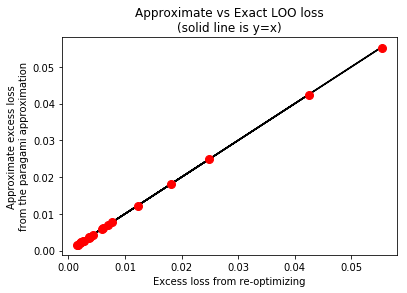

In [132]:
def obs_n_excess_loss(norm_param, n):
    return \
        get_loss(norm_param, x[n, :], 1) - \
        get_loss(norm_param_opt, x[n, :], 1)

opt_loo_loss = [ obs_n_excess_loss(opt_loo_params[n], n) for n in opt_n ]
approx_loo_loss = [ obs_n_excess_loss(approx_loo_params[n], n) for n in opt_n ]

plt.plot(opt_loo_loss, opt_loo_loss, 'k')
plt.plot(opt_loo_loss, approx_loo_loss, 'ro', markersize=8)
plt.xlabel('Excess loss from re-optimizing')
plt.ylabel('Approximate excess loss\nfrom the paragami approximation')
plt.title('Approximate vs Exact LOO loss\n(solid line is y=x)')

### Fast tools lead to fun exploratory data analysis!

We can graph LOO sensitivity of various parameters vs $x_{1n}$.

Text(0.5, 0, 'x_{1n}')

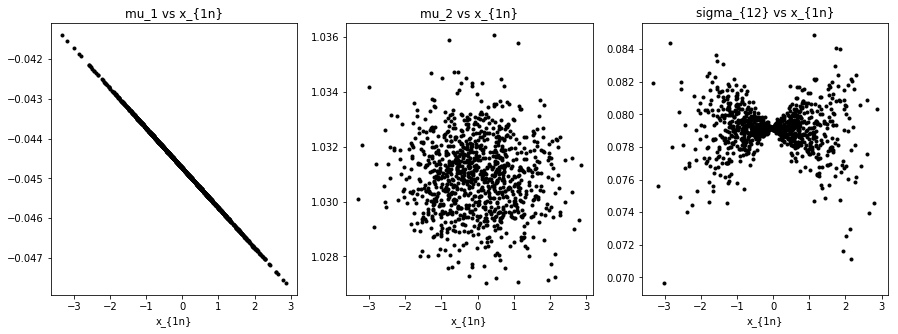

In [107]:
mu_1_loo = [ param['mu'][0] for param in approx_loo_params ]  
mu_2_loo = [ param['mu'][1] for param in approx_loo_params ]  
sigma_12_loo = [ param['sigma'][0, 1] for param in approx_loo_params ]  

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(x[:, 0], mu_1_loo, 'k.')
plt.title('mu_1 vs x_{1n}')
plt.xlabel('x_{1n}')

plt.subplot(1, 3, 2)
plt.plot(x[:, 0], mu_2_loo, 'k.')
plt.title('mu_2 vs x_{1n}')
plt.xlabel('x_{1n}')

plt.subplot(1, 3, 3)
plt.plot(x[:, 0], sigma_12_loo, 'k.')
plt.title('sigma_{12} vs x_{1n}')
plt.xlabel('x_{1n}')


We can examine the excess loss versus the data.

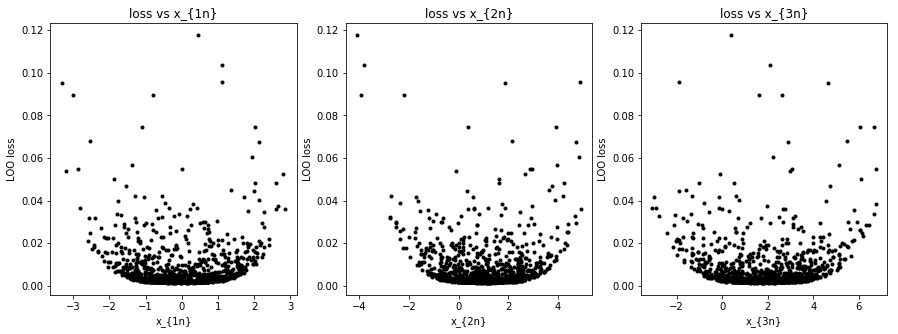

In [120]:
def obs_n_loss(norm_param, n):
    return \
        get_loss(norm_param, x[n, :], 1) - \
        get_loss(norm_param_opt, x[n, :], 1)

loo_loss = [ obs_n_loss(approx_loo_params[n], n) for n in range(num_obs) ]

# Plot the LOO loss versus each dimension of the data.
plt.figure(figsize=(15, 5))
for dim in range(3):
    plt.subplot(1, 3, dim + 1)
    plt.plot(x[:, dim], loo_loss, 'k.')
    plt.title('loss vs x_{{{}n}}'.format(dim + 1))
    plt.xlabel('x_{{{}n}}'.format(dim + 1))
    plt.ylabel('LOO loss')
